# Contributing Factors to the Falling Life Expectancy in the US

### Sabrina Pereira & Ashley Swanson

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from scipy.stats import linregress
import statsmodels.formula.api as smf

from thinkstats2 import Cdf
import thinkplot
# from survival import SurvivalFunction

## Loading Data

### Life Expectancy Estimates

To examine death rates and life expectancy at birth for the United States, we used the Centers for Disease Control and Prevention's (CDC) National Center for Health Statistics (NCHS) data (Available at: https://data.cdc.gov/NCHS/NCHS-Death-rates-and-life-expectancy-at-birth/w9j2-ggv5). 

Values for 2015-2017 have been published but are not included in the dataset, so we added them manually from the following sources:

   Mortality in the United States, 2015 - https://www.cdc.gov/nchs/products/databriefs/db267.htm
   
   Mortality in the United States, 2016 - https://www.cdc.gov/nchs/products/databriefs/db293.htm
   
   Mortality in the United States, 2017 - https://www.cdc.gov/nchs/products/databriefs/db328.htm

In [2]:
nchs = pd.read_csv('nchs.csv', sep=',')

# Manually adding the nchs data to a data frame with the most recent data 
d = {'Year': [2017, 2016, 2015], 'Race': 3*['All Races'], 'Sex' : 3*['Both Sexes'], 'Average Life Expectancy (Years)':[78.6,78.7, 78.7], 'Age-adjusted Death Rate': [731.9, 728.8, 733.1]}
df = pd.DataFrame(data=d)
nchs = df.append(nchs.drop([0]), ignore_index=True)

# Select NCHS data that describes all people in the US, from 1999-2017, and in year ascending order
everyone = nchs[(nchs.Race == 'All Races') & (nchs.Sex == 'Both Sexes')]
recent = everyone[everyone.Year > 1998][::-1].reset_index(drop=True)

### Death Rates by Year & Age

To calculate life expectancies, we examined the number of deaths and population sizes for each year and age group from 1999-2017. We drew data from the Multiple Cause of Death Data (Available at https://wonder.cdc.gov/). 

Terms of use: https://wonder.cdc.gov/mcd.html

In [3]:
# Load data
sy_mort = pd.read_csv('Single Year Mortality Data, 1999-2017.txt', sep='\t')

# Extract total deaths
sy_mort_totals = sy_mort[(sy_mort.Notes == 'Total') & (sy_mort.Year.notna())].reset_index(drop=True)

# Clean data to only include rows with valid years
sy_mort = sy_mort[(sy_mort.Year.notna()) & (sy_mort['Single-Year Ages Code'] != 'NS') & (sy_mort.Notes.isna())]
sy_mort.replace('Not Applicable',np.nan, inplace=True)

sy_mort.head()

,Notes,Year,Year Code,Single-Year Ages,Single-Year Ages Code,Deaths,Population,Crude Rate
0,NaN,1999.0,1999.0,< 1 year,0,27937.0,3795762,736.0
1,NaN,1999.0,1999.0,1 year,1,1989.0,3785088,52.5
2,NaN,1999.0,1999.0,2 years,2,1376.0,3782635,36.4
3,NaN,1999.0,1999.0,3 years,3,1046.0,3824806,27.3
4,NaN,1999.0,1999.0,4 years,4,838.0,3947253,21.2


### Opioid-Related Deaths

Similary, we examined deaths due to opioid overdose by age and year from 1999-2017 using this same dataset. 

We requested data using "MCD - ICD-10 Codes," and we used the CDC's definition of the ICD-10 codes that related to "All opioid poisoning" (the chart containing the codes fitting this definition is available at https://www.cdc.gov/drugoverdose/pdf/pdo_guide_to_icd-9-cm_and_icd-10_codes-a.pdf )

Terms of use: https://wonder.cdc.gov/mcd-icd10.html

In [4]:
# Load data
op_mort = pd.read_csv('Single Year Opioid Mortality Data, 1999-2017.txt', sep='\t')

# Extract total deaths
op_mort_totals = op_mort[(op_mort.Notes == 'Total') & (op_mort.Year.notna())].reset_index(drop=True)

# Clean data to only include rows with valid years
op_mort = op_mort[(op_mort.Year.notna()) & (op_mort['Single-Year Ages Code'] != 'NS') & (op_mort.Notes.isna())]
op_mort.replace('Not Applicable',np.nan, inplace=True)

op_mort.head()

,Notes,Year,Year Code,Single-Year Ages,Single-Year Ages Code,Deaths,Population,Crude Rate
0,NaN,1999.0,1999.0,< 1 year,0,20.0,3795762,0.5
1,NaN,1999.0,1999.0,1 year,1,12.0,3785088,Unreliable
2,NaN,1999.0,1999.0,2 years,2,5.0,3782635,Unreliable
3,NaN,1999.0,1999.0,3 years,3,4.0,3824806,Unreliable
4,NaN,1999.0,1999.0,4 years,4,4.0,3947253,Unreliable


### Deaths by Suicide 

We also analyzed suicide rates by age and year from 199-2017 using the Multiple Cause of Death Data. 

We requested the data using "MCD - ICD-10 113 Cause List" with the cause "GR113-124 Intentional self-harm (suicide) (*U03,X60-X84,Y87.0)"

Terms of use: https://wonder.cdc.gov/mcd-icd10.html

In [ ]:
# Load data
su_mort = pd.read_csv('Single Year Suicide Mortality Data, 1999-2017.txt', sep='\t')

# Extract total deaths
su_mort_totals = su_mort[(su_mort.Notes == 'Total') & (su_mort.Year.notna())].reset_index(drop=True)

# Clean data to only include rows with valid years
su_mort = su_mort[(su_mort.Year.notna()) & (su_mort['Single-Year Ages Code'] != 'NS') & (su_mort.Notes.isna())]
su_mort.replace('Not Applicable',np.nan, inplace=True)

su_mort.head()

,Notes,Year,Year Code,Single-Year Ages,Single-Year Ages Code,Deaths,Population,Crude Rate
0,NaN,1999.0,1999.0,7 years,7,1.0,4163303,Unreliable
1,NaN,1999.0,1999.0,9 years,9,1.0,4230069,Unreliable
2,NaN,1999.0,1999.0,10 years,10,7.0,4148653,Unreliable
3,NaN,1999.0,1999.0,11 years,11,22.0,4036182,0.5
4,NaN,1999.0,1999.0,12 years,12,32.0,4009910,0.8


## **Introduction**

In recent years, a downward trend in the Average Life Expectancy (ALE) in the US has emerged, reversing the longstanding trend of steady increase in ALE.

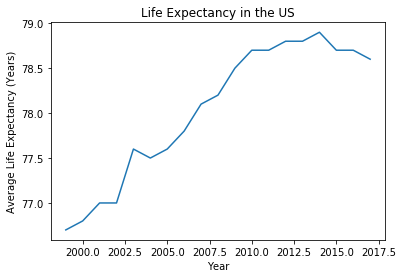

In [ ]:
plt.plot(recent.Year, recent['Average Life Expectancy (Years)'])

plt.xlabel('Year')
plt.ylabel('Average Life Expectancy (Years)')
plt.title('Life Expectancy in the US');


At the same time, the number of opioid related deaths has been increasing with a sharp up-tick in the past five years. Rates of suicide have also been increasing, but as of 2011, the rates of opioid related deaths have overtaken those related to suicide.

Accordingly, we were curious if these factors have contributed substantially to this recent downward trend. 

(5, 22)

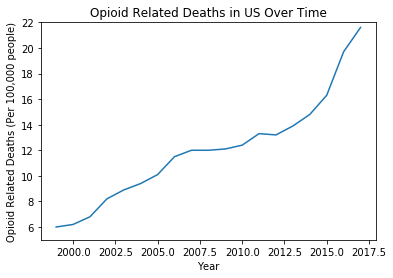

In [ ]:
plt.plot(op_mort_totals.Year, op_mort_totals['Crude Rate'].astype('float64'))
plt.xlabel('Year')
plt.ylabel('Opioid Related Deaths (Per 100,000 people)')
plt.title('Opioid Related Deaths in US Over Time');
plt.ylim(5, 22)

(5, 22)

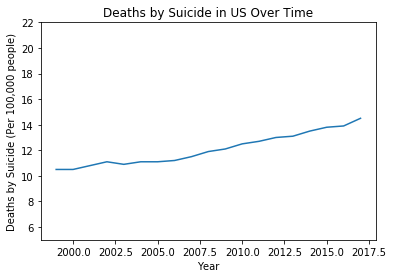

In [ ]:
plt.plot(su_mort_totals.Year, su_mort_totals['Crude Rate'].astype('float64'))
plt.xlabel('Year')
plt.ylabel('Deaths by Suicide (Per 100,000 people)')
plt.title('Deaths by Suicide in US Over Time');
plt.ylim(5, 22)

## **Methodology**

To be able to find out what effect the deaths for a given cause of death have had on the life expectancy in the US, we created a function to model what the populations would look like if no one had died for that specified cause of death. We will do this by subtracting those deaths related to a chosen cause of death from the total deaths by age group. 

In our case, we will be modeling populations for a Zero-Opioid Scenario (a theoretical scenario where any deaths related to opioid overdoses do not occur) and a Zero-Suicide Scenario (a theoretical scenario where any deaths by suicide do not occur).


In [ ]:
def make_zero_var_scenario(df):
    '''
    Takes in a DataFrame for the mortality data for a given cause of death.
    Returns a modified version of sy_mort where the deaths in the input DataFrame are removed. 
    
    '''
    mod_df = sy_mort.copy(deep=True)
    
    # Iterate through years and ages
    for year in range(1999,2018):
        for age in range(0,101):
            
            # Find if death count is available for a given combo of age and year to subtract
            df_index = df[(df['Year'] == year) & (df['Single-Year Ages Code'].astype('int64')==age)].first_valid_index()
            if df_index == None:
                df_deaths = 0
            else:
                df_deaths = df.at[df_index, 'Deaths']

            z_index = mod_df[(mod_df['Year'] == year) & (mod_df['Single-Year Ages Code'].astype('int64')==age)].first_valid_index()
            mod_df.at[z_index, 'Deaths'] = mod_df.at[z_index, 'Deaths'] - df_deaths
            
    return mod_df

Because the dataset does not contain population estimates for respondents 85 and older, we needed to estimate these values.

To do this, we chose to look at the total population of 84-year-olds and subract the death count of 85-year-olds to estimate the population of 85-year-olds. However, if we contine to do this for the remaining ages, the final population is not zero because the changes to the 84-year-old population actually appeare in the 85-year old population in the following year.

Accordingly, we looked at the 84-year-old population and divided it by the sum of deaths from age 85-100+ for that year. This gave us a scale factor that allowed us to spread this discrepancy out accross the data while retaining the proportional changes in population each year. 

In [ ]:
def estimating_pop(df):
    
    for year in range(1999,2018):
        #index at 84 years old for the given year
        df_index = df[(df['Year'] == year) & (df['Single-Year Ages Code'].astype('int64')==84)].first_valid_index() 
        temp = df[(df['Year']==year) & (df['Single-Year Ages Code'].astype('int64')>=85)]


        pop = int(df.at[df_index, 'Population'])

        factor = pop/temp['Deaths'].sum()
        df_index += 1

        for age in range(85,101):
            pop = pop - int(df.at[df_index, 'Deaths']*factor)
            df.at[df_index, 'Population'] = pop
            df_index += 1
    

To create a function to calculate the ALE for every year, we looked to the CDC's *A Method for Constructing
Complete Annual U.S. Life Tables* for the formulas they use in calculating the probability of death (q<sub>x</sub>) and the survival function (l<sub>x</sub>) to compute the life expectancy at every age. The life expectancy at birth is the ALE.

In [ ]:
def life_expect_df(df):
    
    '''
    Takes in a DataFrame with the modified mortality data for a Zero-(Cause of Death) Scenario.
    Returns a DataFrame containing the ALEs at birth for this scenario
    
    '''   
    

    df['qx'] = df['Deaths']/(df['Population'].astype('float64')+.5*df['Deaths'])
    df['lx'] = df['Single-Year Ages Code'][::].astype('float64')
    df['lx'].replace(0,100000, inplace=True)

    for year in range(1999,2018):
        df_index = df[df.Year == year].first_valid_index()+1

        for age in range(1,101):
            df.at[df_index,'lx'] = df.at[(df_index-1),'lx'] *(1-df.at[df_index-1,'qx'])
            df_index+=1

    df['dx'] = df['lx']*df['qx']
    df['Lx'] = df['lx'] - .5*df['dx']
    df['Tx'] = 0.0
    
    for year in range(1999,2018):
        df_index = df[df.Year == year].first_valid_index()

        for age in range(0,101):
            temp = df[(df.Year == year) & (df['Single-Year Ages Code'].astype('int64') >= age)]        
            df.at[df_index,'Tx'] = temp['Lx'].sum()
            df_index+=1

    df['ex'] = df['Tx']/df['lx']
    birth_le = df[df['Single-Year Ages Code'].astype('int64')==0] 
    
    return birth_le.reset_index(drop=True)


Graphed below are both the ALEs reported by the NCHS and the ones we calculated. This graph is visual validation for our calculations, as it traces the true ALE very closely.

Around the year 2003, we see that our model for the ALE differs from the true ALE more than any other year, so our results for modeling what the ALE would look like under our different scenarios will not be as accurate around this year as they would be for the other given years. However, we are more concerned with the downward trend in the ALE in the most recent years, and our model is a very good fit for the most recent years.

The close fit of our model indicates that we can create a good estimate of what the life expectancy we would expect to see when we remove the effects of a given cause of death.

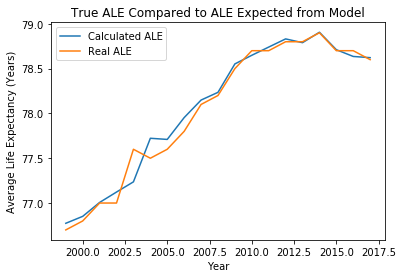

In [ ]:
estimating_pop(sy_mort)
birth_le = life_expect_df(sy_mort)


plt.plot(recent.Year, birth_le['ex'], label='Calculated ALE')
plt.plot(recent.Year, recent['Average Life Expectancy (Years)'], label='Real ALE')

plt.xlabel('Year')
plt.ylabel('Average Life Expectancy (Years)')
plt.title('True ALE Compared to ALE Expected from Model')
plt.legend();

In [ ]:
# birth_le['Year2'] = birth_le['Year']**2

# model = smf.ols('ex ~ Year + Year2', data=birth_le)
# results = model.fit()
# results.summary()


# plt.plot(recent.Year, recent['Average Life Expectancy (Years)'], label='Real ALE')

# pred = results.predict(birth_le)
# plt.plot(birth_le['Year'], pred, label='Calculated ALE')

# plt.xlabel('Year')
# plt.ylabel('Average Life Expectancy (Years)')
# plt.title('True ALE Compared to ALE Expected from Model')
# plt.legend();

In [ ]:
noise = recent['Average Life Expectancy (Years)'] - pred
noise
pdf_noise = Cdf(noise)

thinkplot.cdf(pdf_noise, label='noise');
thinkplot.Show(title='Distribution of Noise',xlabel='Error', ylabel='Pdf');


## **Results**

Here the calculated ALE's from our model and the Zero-Opioid Scenario ALE's are graphed. In the earlier years, the ALE for a Zero-Opioid Scenario differs very little from the actual ALE. However, in the most recent years, the gap between the two is wider than it has ever been. 

In [ ]:
# Create mortality data DataFrames for a Zero-Suicide Scenario 
zero_op_mort = make_zero_var_scenario(op_mort)
estimating_pop(zero_op_mort)
birth_le_mod_op = life_expect_df(zero_op_mort)

plt.plot(recent.Year, birth_le['ex'], label='Calculated ALE')
plt.plot(recent.Year, birth_le_mod_op['ex'], label='Zero-Opioid ALE')

plt.xlabel('Year')
plt.ylabel('Average Life Expectancy (Years)')
plt.title('Difference in ALE compared to a Zero-Opioid Scenario')
plt.legend();

Here the calculated ALE's from our model and the Zero-Suicide Scenario ALE's are graphed. In the earlier years, the ALE's for a Zero-Suicide Scenario differ much more from the actual ALE than the ALE's for a Zero-Opioid Scenario. However, the contribution of suicides on lowering the ALE is not nearly as drastic as opioid related deaths have been. At a point, the difference between the calculated ALE's and the Zero-Opioid Scenario ALE's becomes greater than the difference between the calculated ALE's and the Zero-Suicide Scenario ALE's. 

This indicated that historically, suicides have been a larger factor in lowering the life expectancy, but the dramatic increase in opioid related deaths have notably contributed to ALE decreasing.

In [ ]:
print((birth_le_mod_op['ex'][:8]-birth_le['ex'][:8]).sum()/8, "years") #average difference predating 2007

In [ ]:
print(birth_le_mod_op['ex'][18] - birth_le['ex'][18], "years") ##differnce in 2017

In [ ]:
# Create mortality data DataFrames for a Zero-Suicide Scenario 
zero_su_mort = make_zero_var_scenario(su_mort)
estimating_pop(zero_su_mort)
birth_le_mod_su = life_expect_df(zero_su_mort)

plt.plot(recent.Year, birth_le['ex'], label='Calculated ALE')
plt.plot(recent.Year, birth_le_mod_su['ex'], label='Zero-Suicide ALE')

plt.xlabel('Year')
plt.ylabel('Average Life Expectancy (Years)')
plt.title('Difference in ALE compared to a Zero-Suicide Scenario')
plt.legend();

In [ ]:
print((birth_le_mod_su['ex'][:8]-birth_le['ex'][:8]).sum()/8, "years") #average difference predating 2007

In [ ]:
print(birth_le_mod_su['ex'][18] - birth_le['ex'][18], "years") #differnce in 2017

According to the model, the ALE in 2017 would have been about 0.60 years higher if there had been no opioid-related deaths (79.22 years, compared to the observed 78.6 years). Similarly, in 2016 the ALE would have been 0.48 years higher in a Zero-Opioid Scenario (79.18 years compared to the observed 78.7).

It is only recently that these deaths have created an observable effect this large. Prior to 2007, the average difference between the Zero-Opioid ALE and the observed ALE was 0.22 years.

If there had been no deaths by suicide, the ALE in 2017 would have been about 0.38 years higher (79.00 years, compared to the observed 78.6 years). Similarly, in 2016 the ALE would have been 0.36 years higher in a Zero-Opioid Scenario (79.00 years compared to the observed 78.7). Predating 2007, the average difference between the Zero-Suicide ALE and the observed ALE was 0.27 years. 


Taking all of this into account, it appears that although suicides do lower the life expectancy, they have done so at a relatively constant rate across years. It is the opioid related deaths that seem to have affected the statistic so much that the trend has turned downwards.
